# Temporal and spatial completeness of the Aerosol Optical Depth (AOD) from SLSTR for seasonal Variability analysis
&nbsp;

Production date: 30-09-2024

Produced by: Consiglio Nazionale delle Ricerche ([CNR](https://www.cnr.it/en)
)

## 🌍 Use case: Seasonal Variability of AOD from Satellite Observations
## ❓ Quality assessment questions

**• Can satellite data consistently and homogeneously capture the seasonal variability of AOD in different parts of the world?**

**• Is the temporal coverage of aerosol satellite data sufficient to characterize the aerosol global distribution in the period 2017-2023?**

In the context of climate change and natural atmospheric variability, understanding the spatial and temporal distribution of aerosols is crucial for analyzing phenomena such as air quality, global warming, and public health. Seasonal variations in aerosols are influenced by numerous factors, including biological cycles, seasonal fires, desert dust, and industrial activities [1, 2, 3]. However, uncertainties in satellite data, stemming from limitations in temporal coverage and spatial resolution, could affect our ability to draw reliable conclusions [1].

This assessment evaluates the ability of SLSTR (Sea and Land Surface Temperature Radiometer)-derived satellite data to consistently and homogeneously capture the seasonal variability of Aerosol Optical Depth (AOD) across different global regions. The central question we aim to answer is whether satellite data, despite their limitations and uncertainties, can accurately capture the atmospheric dynamics that influence the distribution of aerosols over the years [2, 4].

The dataset used in this study is the CDS (Copernicus Data Store) AOD product derived from SLSTR onboard Sentinel-3, providing monthly gridded AOD values at 550 nm at approximately 1° spatial resolution in NetCDF format, covering the period 2017–2023.

In summary, this study investigates whether SLSTR data can be reliably used to monitor the seasonal variability of AOD by comparing different geographic regions and assessing whether the spatial coverage is sufficient to characterize AOD distribution globally. 

The results show that the satellite-derived AOD estimates are consistent with other findings reported in the literature [1, 4, 5] and are supported by a thorough scientific analysis. This consistency suggests that SLSTR data can be a robust tool for monitoring global aerosol distribution.

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note

• The SLSTR aerosol data exhibits consistency with other satellite-derived datasets, particularly in regions like Southern Africa and Southeast Asia [3, 6]. 

• Coarse-mode AOD trends over North Africa and the Mediterranean Basin align with findings from previous studies, such as Cuevas-Agulló et al. (2024), highlighting an increase in dust intrusions during 2020–2022 [2].

• The absence of data for several months in East Asia and Siberia restricts a full understanding of regional aerosol dynamics.

• A weaker correlation between Fine Mode AOD and Total AOD in regions like North Africa and India suggests the presence of varying aerosol types and the influence of mineral dust transport.

## 📋 Methodology

This notebook aims to assess the consistency and completeness of SLSTR-derived satellite data in capturing the seasonal variability of Aerosol Optical Depth (AOD) over different global regions from 2017 to 2023.

The methodology adopted for the analysis is split into the following steps:

[](section-1) 
* Import all required libraries  
* Spatial and temporal definitions  

[](section-2)  
* Download AOD data  
* Computation of time series  
* Define required functions   

[](section-3)  
* Prepare the dataframe  
* Global map plots: mean AOD and FM-AOD  
* Regional AOD and FM-AOD time series plots  
* Observation count plot for AOD550 averages  
* Scatter plot of fine-mode AOD vs. total AOD  

[](section-4) 

## 📈 Analysis and results
(section-1)=
### 1. Choose the data to use and set up the code

#### Import all required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [9]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.dates as mdates  
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
import warnings

#### Spatial and temporal definitions

The analysis performed in this notebook focuses on data from July 2017 to June 2023, using monthly averages from the SLSTR sensor on Sentinel-3A. The regions are grouped into meaningful areas like North America, Europe, Africa, and Asia, each defined by specific latitude and longitude ranges. These subregions are color-coded for easy comparison in plots. 

In [10]:

time_dict = {
    "start": "2017-07",
    "stop": "2023-06"
}

request = {
    "time_aggregation": "monthly_average",
    "variable": ["aerosol_optical_depth"],
    "sensor_on_satellite": "slstr_on_sentinel_3a",
    "algorithm": "ens",
    "version": "v2_3",
    "format": "zip"
}

collection_id = "satellite-aerosol-properties"
requests = download.update_request_date(
    request,
    **time_dict,
    stringify_dates=True
)

# Assign time dimension and compute means

time_values = pd.date_range(start="2017-07-01", end="2023-06-30", freq="MS")

# Optional color palette for consistency
colors = {
    "Western North America": "#1f77b4",
    "Eastern North America": "#ff7f0e",
    "Continental Europe": "#2ca02c",
    "Mediterranean Basin": "#d62728",
    "South America": "#9467bd",
    "Southern Africa": "#8c564b",
    "Indonesia": "#e377c2",
    "North Africa (Sahara)": "#7f7f7f",
    "India": "#bcbd22",
    "Siberia": "#17becf",
    "Southeast Asia": "#aec7e8",
    "East Asia": "#ffbb78",
    "China": "#ff0000"
}

# Define subregions
subregions = {
    "Northern Industrial Economies": {
        "Western North America": {"lat_min": 35, "lat_max": 50, "lon_min": -125, "lon_max": -100},
        "Eastern North America": {"lat_min": 35, "lat_max": 50, "lon_min": -85, "lon_max": -60},
        "Continental Europe": {"lat_min": 45, "lat_max": 55, "lon_min": -10, "lon_max": 30},
        "Mediterranean Basin": {"lat_min": 30, "lat_max": 45, "lon_min": -10, "lon_max": 40},
    },
    "Southern Biomass Burning": {
        "South America": {"lat_min": -56, "lat_max": -12, "lon_min": -80, "lon_max": -35},
        "Southern Africa": {"lat_min": -30, "lat_max": -10, "lon_min": 10, "lon_max": 40},
        "Indonesia": {"lat_min": -10, "lat_max": 5, "lon_min": 95, "lon_max": 140},
    },
    "Dust Dominated Regions": {
        "North Africa (Sahara)": {"lat_min": 15, "lat_max": 30, "lon_min": -15, "lon_max": 30},
        "India": {"lat_min": 10, "lat_max": 30, "lon_min": 70, "lon_max": 90},
    },
    "Asia": {
        "Siberia": {"lat_min": 55, "lat_max": 70, "lon_min": 80, "lon_max": 130},
        "Southeast Asia": {"lat_min": 5, "lat_max": 20, "lon_min": 95, "lon_max": 110},
        "East Asia": {"lat_min": 30, "lat_max": 45, "lon_min": 110, "lon_max": 135},
        "China": {"lat_min": 20, "lat_max": 45, "lon_min": 100, "lon_max": 125}
    }
}



(section-2)=
### 2. Data Retrieval and Preparation

In this step, the selected satellite data is downloaded using predefined time and variable settings. The data is then formatted to include a clear time coordinate, and average maps of key variables like AOD550 and FM_AOD550 are calculated over the full time period to prepare for analysis and visualization.

#### Download AOD data

In [7]:
ds = download.download_and_transform(
    collection_id=collection_id,
    requests=requests,
    chunks={"year": 1, "month": 1}
)
print(ds)


100%|██████████| 72/72 [00:04<00:00, 15.88it/s]


<xarray.Dataset> Size: 75MB
Dimensions:                      (source: 72, latitude: 180, longitude: 360)
Coordinates:
  * source                       (source) object 576B '148c29e9a49fd1261d149a...
  * latitude                     (latitude) float32 720B -89.5 -88.5 ... 89.5
  * longitude                    (longitude) float32 1kB -179.5 -178.5 ... 179.5
Data variables:
    AOD550                       (source, latitude, longitude) float32 19MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    FM_AOD550                    (source, latitude, longitude) float32 19MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    AOD550_UNCERTAINTY_ENSEMBLE  (source, latitude, longitude) float32 19MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    NMEAS                        (source, latitude, longitude) float32 19MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/18)
    Conventions:               CF-1.6
    creator_email:             thomas.popp@dlr.de
  

#### Computation of time series

To analyze changes over time, a monthly time coordinate was created and assigned to the dataset. The data’s internal “source” dimension was replaced with this new time axis, allowing for clear temporal analysis. Then, the mean values of AOD550 and FM_AOD550 were calculated across the full time period, producing overall average maps for these key aerosol indicators.

In [11]:
# Assign time dimension and compute means

time_values = pd.date_range(start="2017-07-01", end="2023-06-30", freq="MS")

# Add time as a coordinate based on the 'source' dimension
ds = ds.assign_coords(time=("source", time_values))


ds = ds.swap_dims({"source": "time"})


mean_aod = ds['AOD550'].mean(dim='time')
mean_fm_aod = ds['FM_AOD550'].mean(dim='time')

df = ds[['AOD550', 'FM_AOD550', 'AOD550_UNCERTAINTY_ENSEMBLE']].to_dataframe().reset_index()
df.replace(-999.0, pd.NA, inplace=True)
df.dropna(subset=['AOD550', 'FM_AOD550'], inplace=True)
df['time'] = pd.to_datetime(df['time'])
df.sort_values("time", inplace=True)
df = ds[['AOD550', 'FM_AOD550','AOD550_UNCERTAINTY_ENSEMBLE']].to_dataframe().reset_index()

#### Define required functions

The following functions were defined to support the analysis of aerosol data:

The function "plot_global_map" creates a global map of AOD values, adding coastlines, borders, and gridlines for geographic context.

"plot_multi_series_aod" generates seasonal time series for each subregion, showing trends in AOD or fine-mode AOD, with uncertainty as a shading.

"plot_observation_counts_with_stats_on_plot" shows how many data points were used in each region per month, helping assess data coverage.

"scatter_fine_vs_total" creates scatter plots comparing total AOD with fine-mode AOD, including regression lines and R² values to reveal correlations across regions.

In [21]:
def plot_global_map(data, title, cmap="viridis", vmin=None, vmax=None):
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs={"label": data.name}
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {"size": 10}
    gl.ylabel_style = {"size": 10}
    ax.set_title(title, fontsize=14)
    plt.show()

def plot_multi_series_aod(df, variable, uncertainty_var=None, title="", ylabel=""):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
    axes = axes.flatten()
    for i, (panel_title, subregion_dict) in enumerate(subregions.items()):
        ax = axes[i]
        for region_name, bounds in subregion_dict.items():
            region_df = df[
                (df['latitude'] >= bounds['lat_min']) &
                (df['latitude'] <= bounds['lat_max']) &
                (df['longitude'] >= bounds['lon_min']) &
                (df['longitude'] <= bounds['lon_max'])
            ]
            monthly_mean = region_df.groupby('time')[variable].mean()
            if uncertainty_var:
                monthly_uncertainty = region_df.groupby('time')[uncertainty_var].mean()
                ax.fill_between(
                    monthly_mean.index,
                    monthly_mean - monthly_uncertainty,
                    monthly_mean + monthly_uncertainty,
                    alpha=0.15,
                    color=colors.get(region_name, None)
                )
            ax.plot(
                monthly_mean.index,
                monthly_mean.values,
                label=region_name,
                color=colors.get(region_name, None),
                linewidth=2
            )
        ax.set_title(panel_title, fontsize=14)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.grid(True)
        ax.legend(loc='upper left', fontsize=9)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

import numpy as np

def plot_observation_counts_with_stats_on_plot(df, variable='AOD550', title="", scale_factor=1e6):
    
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm

    fig, ax = plt.subplots(figsize=(14, 6))

    
    all_regions = {
        name: bounds
        for group in subregions.values()
        for name, bounds in group.items()
    }

    colors = cm.get_cmap('tab20', len(all_regions))

    for idx, (region_name, bounds) in enumerate(all_regions.items()):
        region_df = df[
            (df['latitude'] >= bounds['lat_min']) &
            (df['latitude'] <= bounds['lat_max']) &
            (df['longitude'] >= bounds['lon_min']) &
            (df['longitude'] <= bounds['lon_max'])
        ]
        obs_counts = region_df.groupby('time')[variable].count()

        if obs_counts.empty or obs_counts.sum() == 0:
            continue

        # Calculate area in km² and normalize
        lat_span = bounds['lat_max'] - bounds['lat_min']
        lon_span = bounds['lon_max'] - bounds['lon_min']
        region_area_km2 = lat_span * lon_span * 111**2  # approximate conversion
        normalized_counts = obs_counts / region_area_km2 * scale_factor


        ax.plot(obs_counts.index, normalized_counts.values, label=region_name, color=colors(idx))


    ax.set_title(title or "(normalized by region area)")
    ax.set_ylabel(f"Normalized Observation Density (counts / {int(scale_factor):,} km²)")
    ax.set_xlabel("Time")
    ax.legend(ncol=2, fontsize='small', loc='lower right', bbox_to_anchor=(0.3, 0))
    ax.grid(True)
    plt.tight_layout()
    plt.show()

       
def scatter_fine_vs_total(df, subregions, variable_x='AOD550', variable_y='FM_AOD550'):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    import matplotlib.pyplot as plt

    total_regions = sum(len(r) for r in subregions.values())
    cols = 3
    rows = -(-total_regions // cols)  
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    idx = 0
    for panel, region_set in subregions.items():
        for region_name, bounds in region_set.items():
            region_df = df[
                (df['latitude'] >= bounds['lat_min']) &
                (df['latitude'] <= bounds['lat_max']) &
                (df['longitude'] >= bounds['lon_min']) &
                (df['longitude'] <= bounds['lon_max'])
            ]
            grouped = region_df.groupby('time')[[variable_x, variable_y]].mean().dropna()
            if grouped.empty:
                continue

            x = grouped[variable_x].values.reshape(-1, 1)
            y = grouped[variable_y].values
            model = LinearRegression().fit(x, y)
            y_pred = model.predict(x)
            r2 = r2_score(y, y_pred)
            a = model.coef_[0]
            b = model.intercept_

            ax = axes[idx]
            ax.scatter(x, y, alpha=0.6, label='Monthly Mean')
            ax.plot(x, y_pred, color='red', label=f'y = {a:.2f}x + {b:.2f}\nR² = {r2:.2f}')
            ax.set_title(region_name, fontsize=10)
            ax.set_xlabel('AOD550')
            ax.set_ylabel('FM_AOD550')
            ax.legend()
            ax.grid(True)

            idx += 1

   
    for j in range(idx, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


(section-3)=
### 3.  Plot and describe the results

#### Global map plots: mean AOD and FM-AOD

The first map shows the mean Aerosol Optical Depth (AOD550) over the globe. Higher AOD values, shown in darker orange, are observed over regions with frequent dust storms (e.g. the Sahara), biomass burning (e.g. central Africa), and industrial pollution (e.g. parts of India and China).

The second map displays the mean Fine-mode AOD550, which focuses on smaller particles like smoke, urban pollution, and secondary aerosols, dominating aerosol loading over central Africa, Southeast Asia, and parts of South America. These areas associated with biomass burning and anthropogenic emissions.

Together, these plots help distinguish between regions dominated by coarse-mode aerosols (e.g. dust) and those with higher concentrations of fine-mode particles.

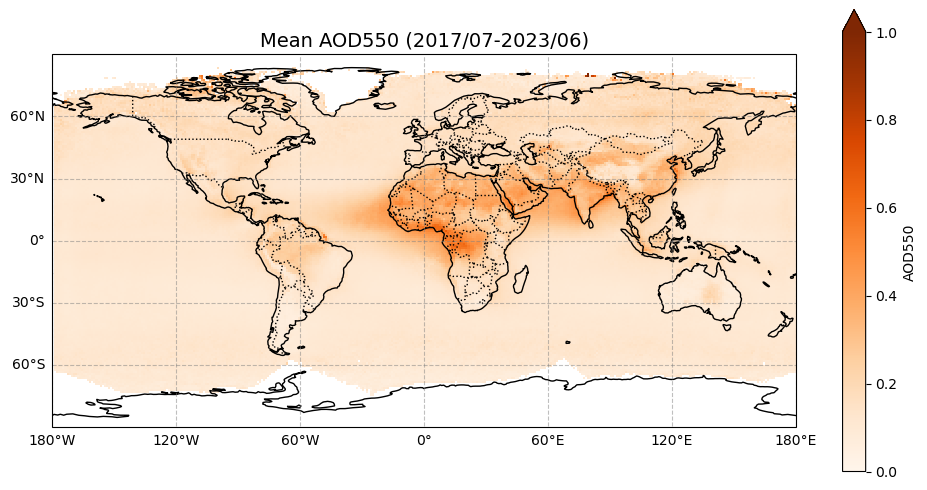

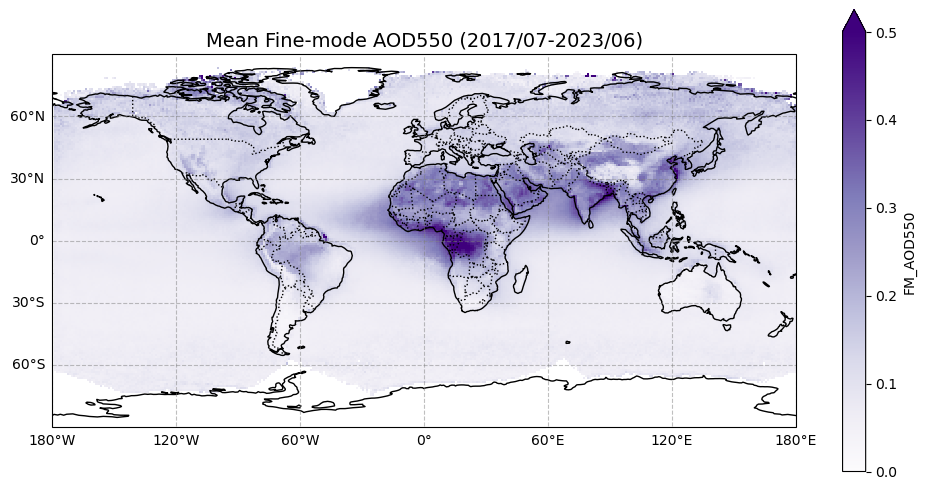

In [19]:
plot_global_map(mean_aod, "Mean AOD550 (2017/07-2023/06)", cmap="Oranges", vmin=0, vmax=1)
plot_global_map(mean_fm_aod, "Mean Fine-mode AOD550 (2017/07-2023/06)", cmap="Purples", vmin=0, vmax=0.5)


*Figure 1.* Global distribution of mean Aerosol Optical Depth (AOD550) and Fine-mode AOD550 from the SLSTR sensor onboard Sentinel-3A, averaged over the period July 2017 to June 2023.

#### Regional AOD and FM-AOD time series plots
The time series of 550 nm AOD monthly means from SLSTR satellite data refer to subregions selected because of the similarity in the observed aerosol types: Northern Industrial Economies, Southern Biomass Burning, Dust-Dominated Regions, and Asia. Each subplot includes shaded uncertainty areas (±1σ) quantifying AOD variability.
In the AOD550 plot, Northern industrial regions display often have AOD peaks in summertime, while, since 2020 the Mediterranean Basin shows high AOD levels throughout the year, strongly influenced by the mineral dust intrusion consistenly with a documented enhancement of dust emissions in Northern Africa [4].
The FM_AOD550 is also reported showing that biomass burning regions, like Southern Africa, have peaks during dry periods typically dominated by foredst fires [2, 3].

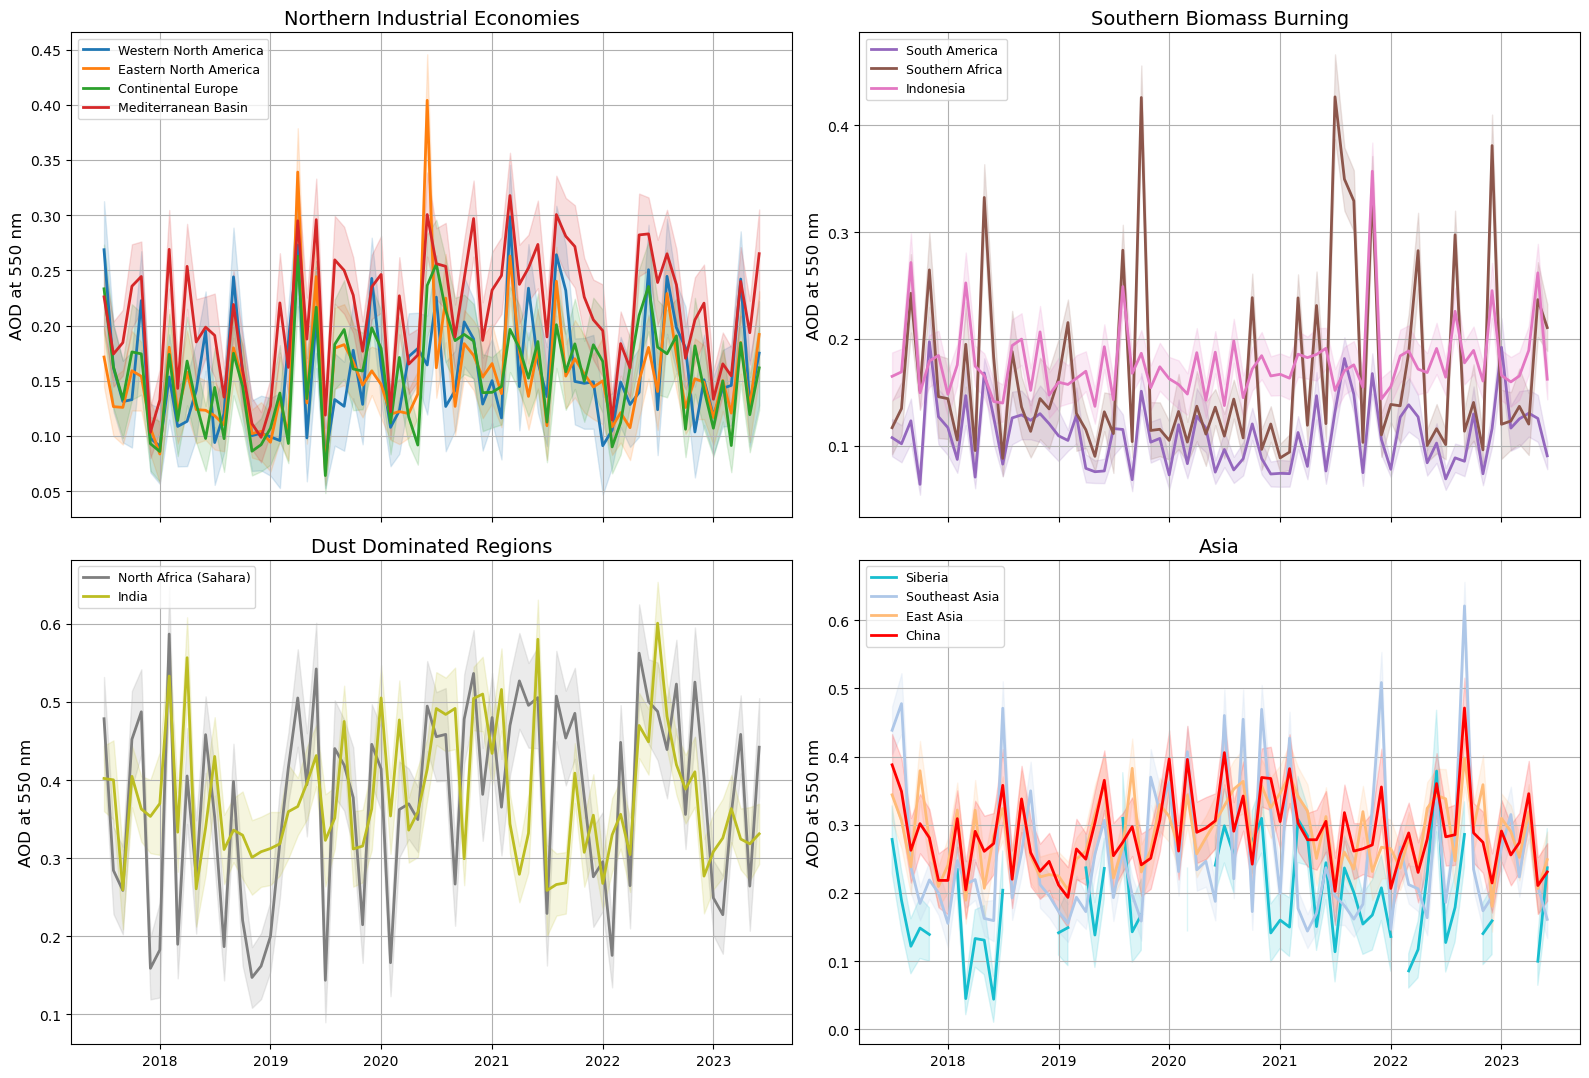

In [9]:
plot_multi_series_aod(
    df,
    variable="AOD550",
    uncertainty_var="AOD550_UNCERTAINTY_ENSEMBLE",
    ylabel="AOD at 550 nm",   
)


*Figure 2.* Monthly mean time series of total AOD at 550 nm from SLSTR for different sub-regions. Each panel shows regional time series with uncertainty as a shaded area (±1σ). Northern industrial regions show peaks in summer. The Mediterranean Basin maintains high AOD values year-round, especially in the period 2020-2022.

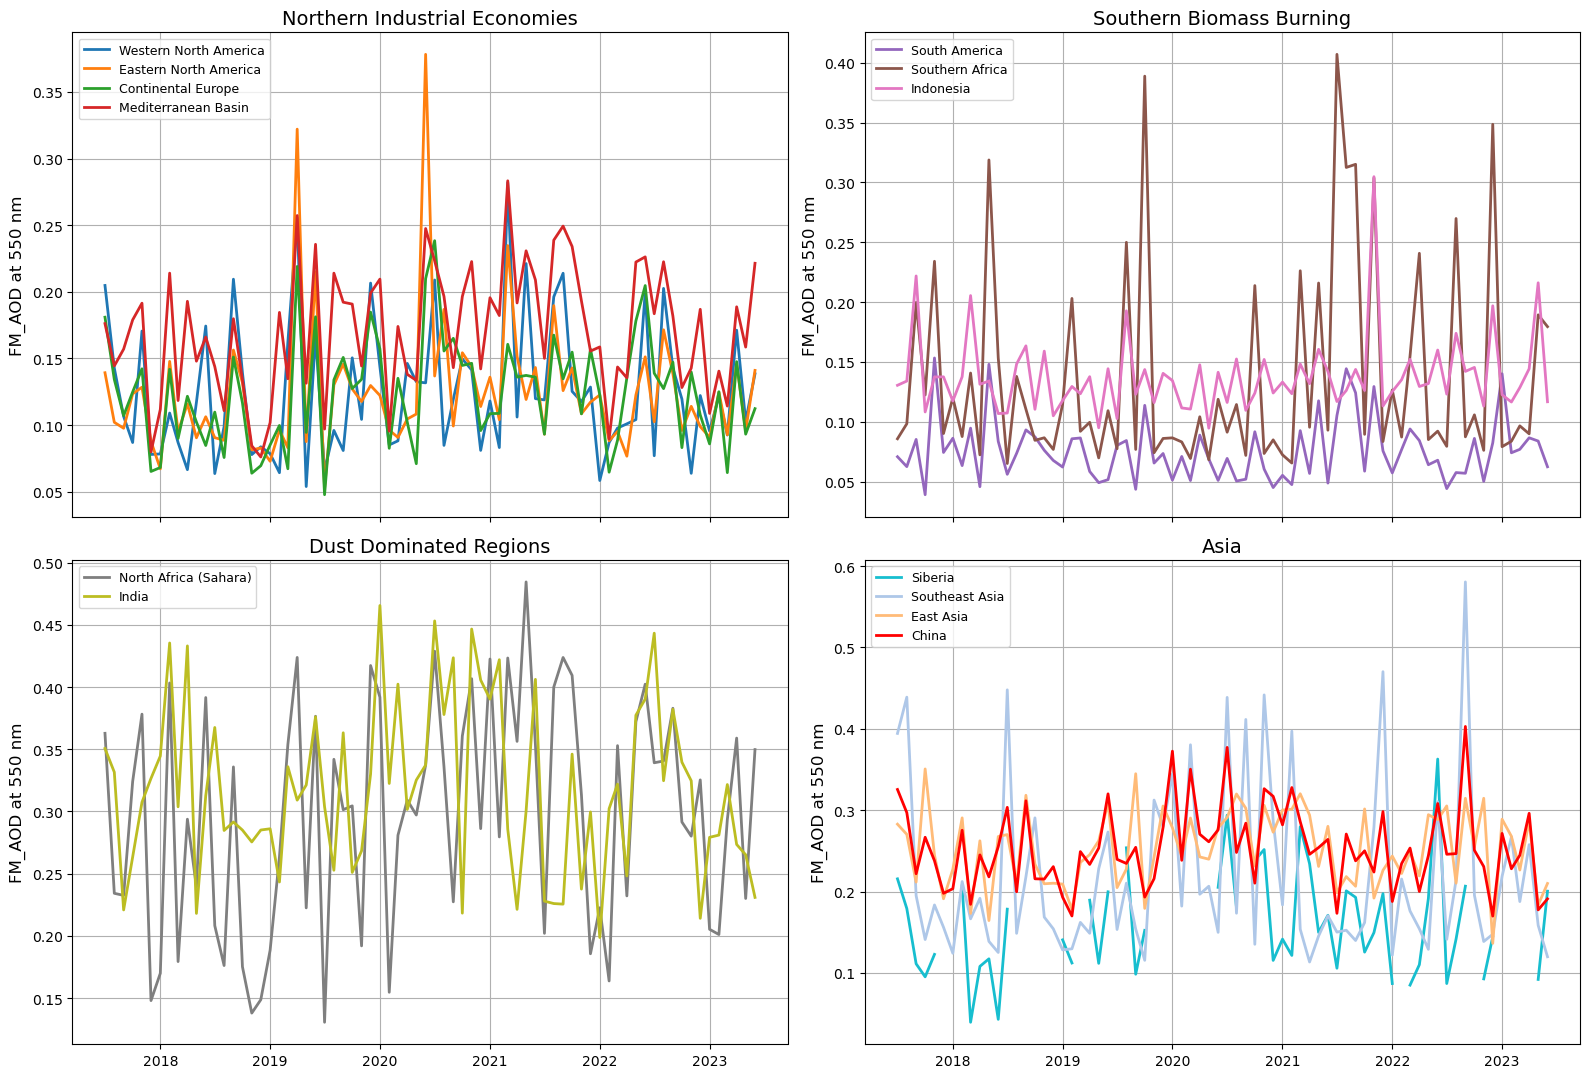

In [10]:
plot_multi_series_aod(
    df,
    variable="FM_AOD550",
    ylabel="FM_AOD at 550 nm",
)


*Figure 3.* Monthly mean time series of fine-mode AOD550 from SLSTR for selected global sub-regions. Fine mode aerosols include smoke, urban pollution, and secondary particles. Biomass burning regions like South America and Southern Africa show peaks during dry periods.

#### Observation count plot for AOD550 Averages

For assessing the spatial completeness of the data used in the time series analysis, this plot displays the normalized observation density, i.e., the number of valid AOD550 observations per 1,000,000 km², used each month to compute regional averages. Each line represents a distinct subregion, allowing visual comparison of data coverage over time, normalized by region size.

Most regions, such as South America, exhibit consistently high normalized observation densities, typically ranging from 60 to 80 counts per 1,000,000 km². In contrast, areas like Siberia show larger variability and lower density, implying a higher uncertainty for the derived monthly statistics and trend assessments.

/data/wp5/.tmp/ipykernel_1160247/3269111212.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(all_regions))


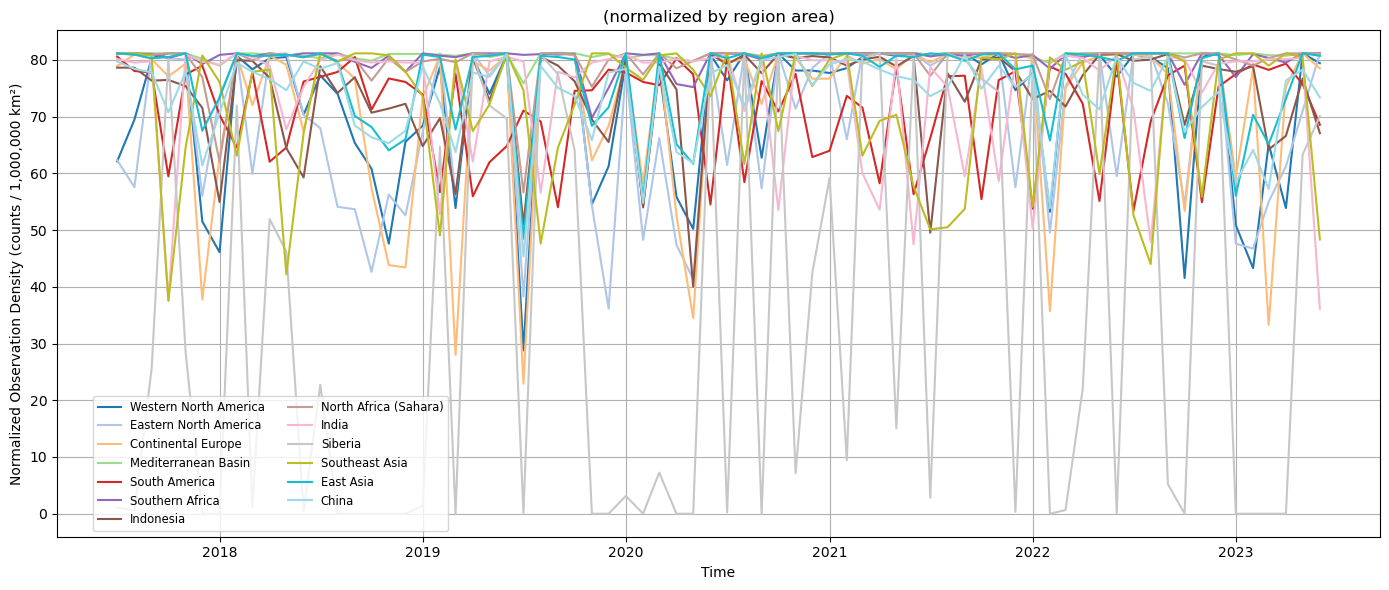

In [22]:
plot_observation_counts_with_stats_on_plot(df, 'AOD550')

*Figure 4.* Number of monthly observations used to calculate AOD averages for each sub-region.

#### Scatter plot of Fine Mode AOD vs total AOD

This figure shows a series of scatter plots comparing Fine Mode Aerosol Optical Depth (FM_AOD550) with Total AOD (AOD550) for each subregion, based on monthly averages. Each subplot includes a red regression line with its corresponding equation and R² value, indicating the strength of the linear relationship.
All regions display a high correlation, suggesting that fine-mode particles—such as smoke, continental aerosols, and anthropogenic pollution—contribute significantly to total aerosol loading.
Regions with smaller R² values, such as North Africa and India, indicate a greater contribution from coarse and giant particles to the total AOD.
These plots are useful for understanding regional differences in aerosol size and type, the latter known the local aerosol climatology.

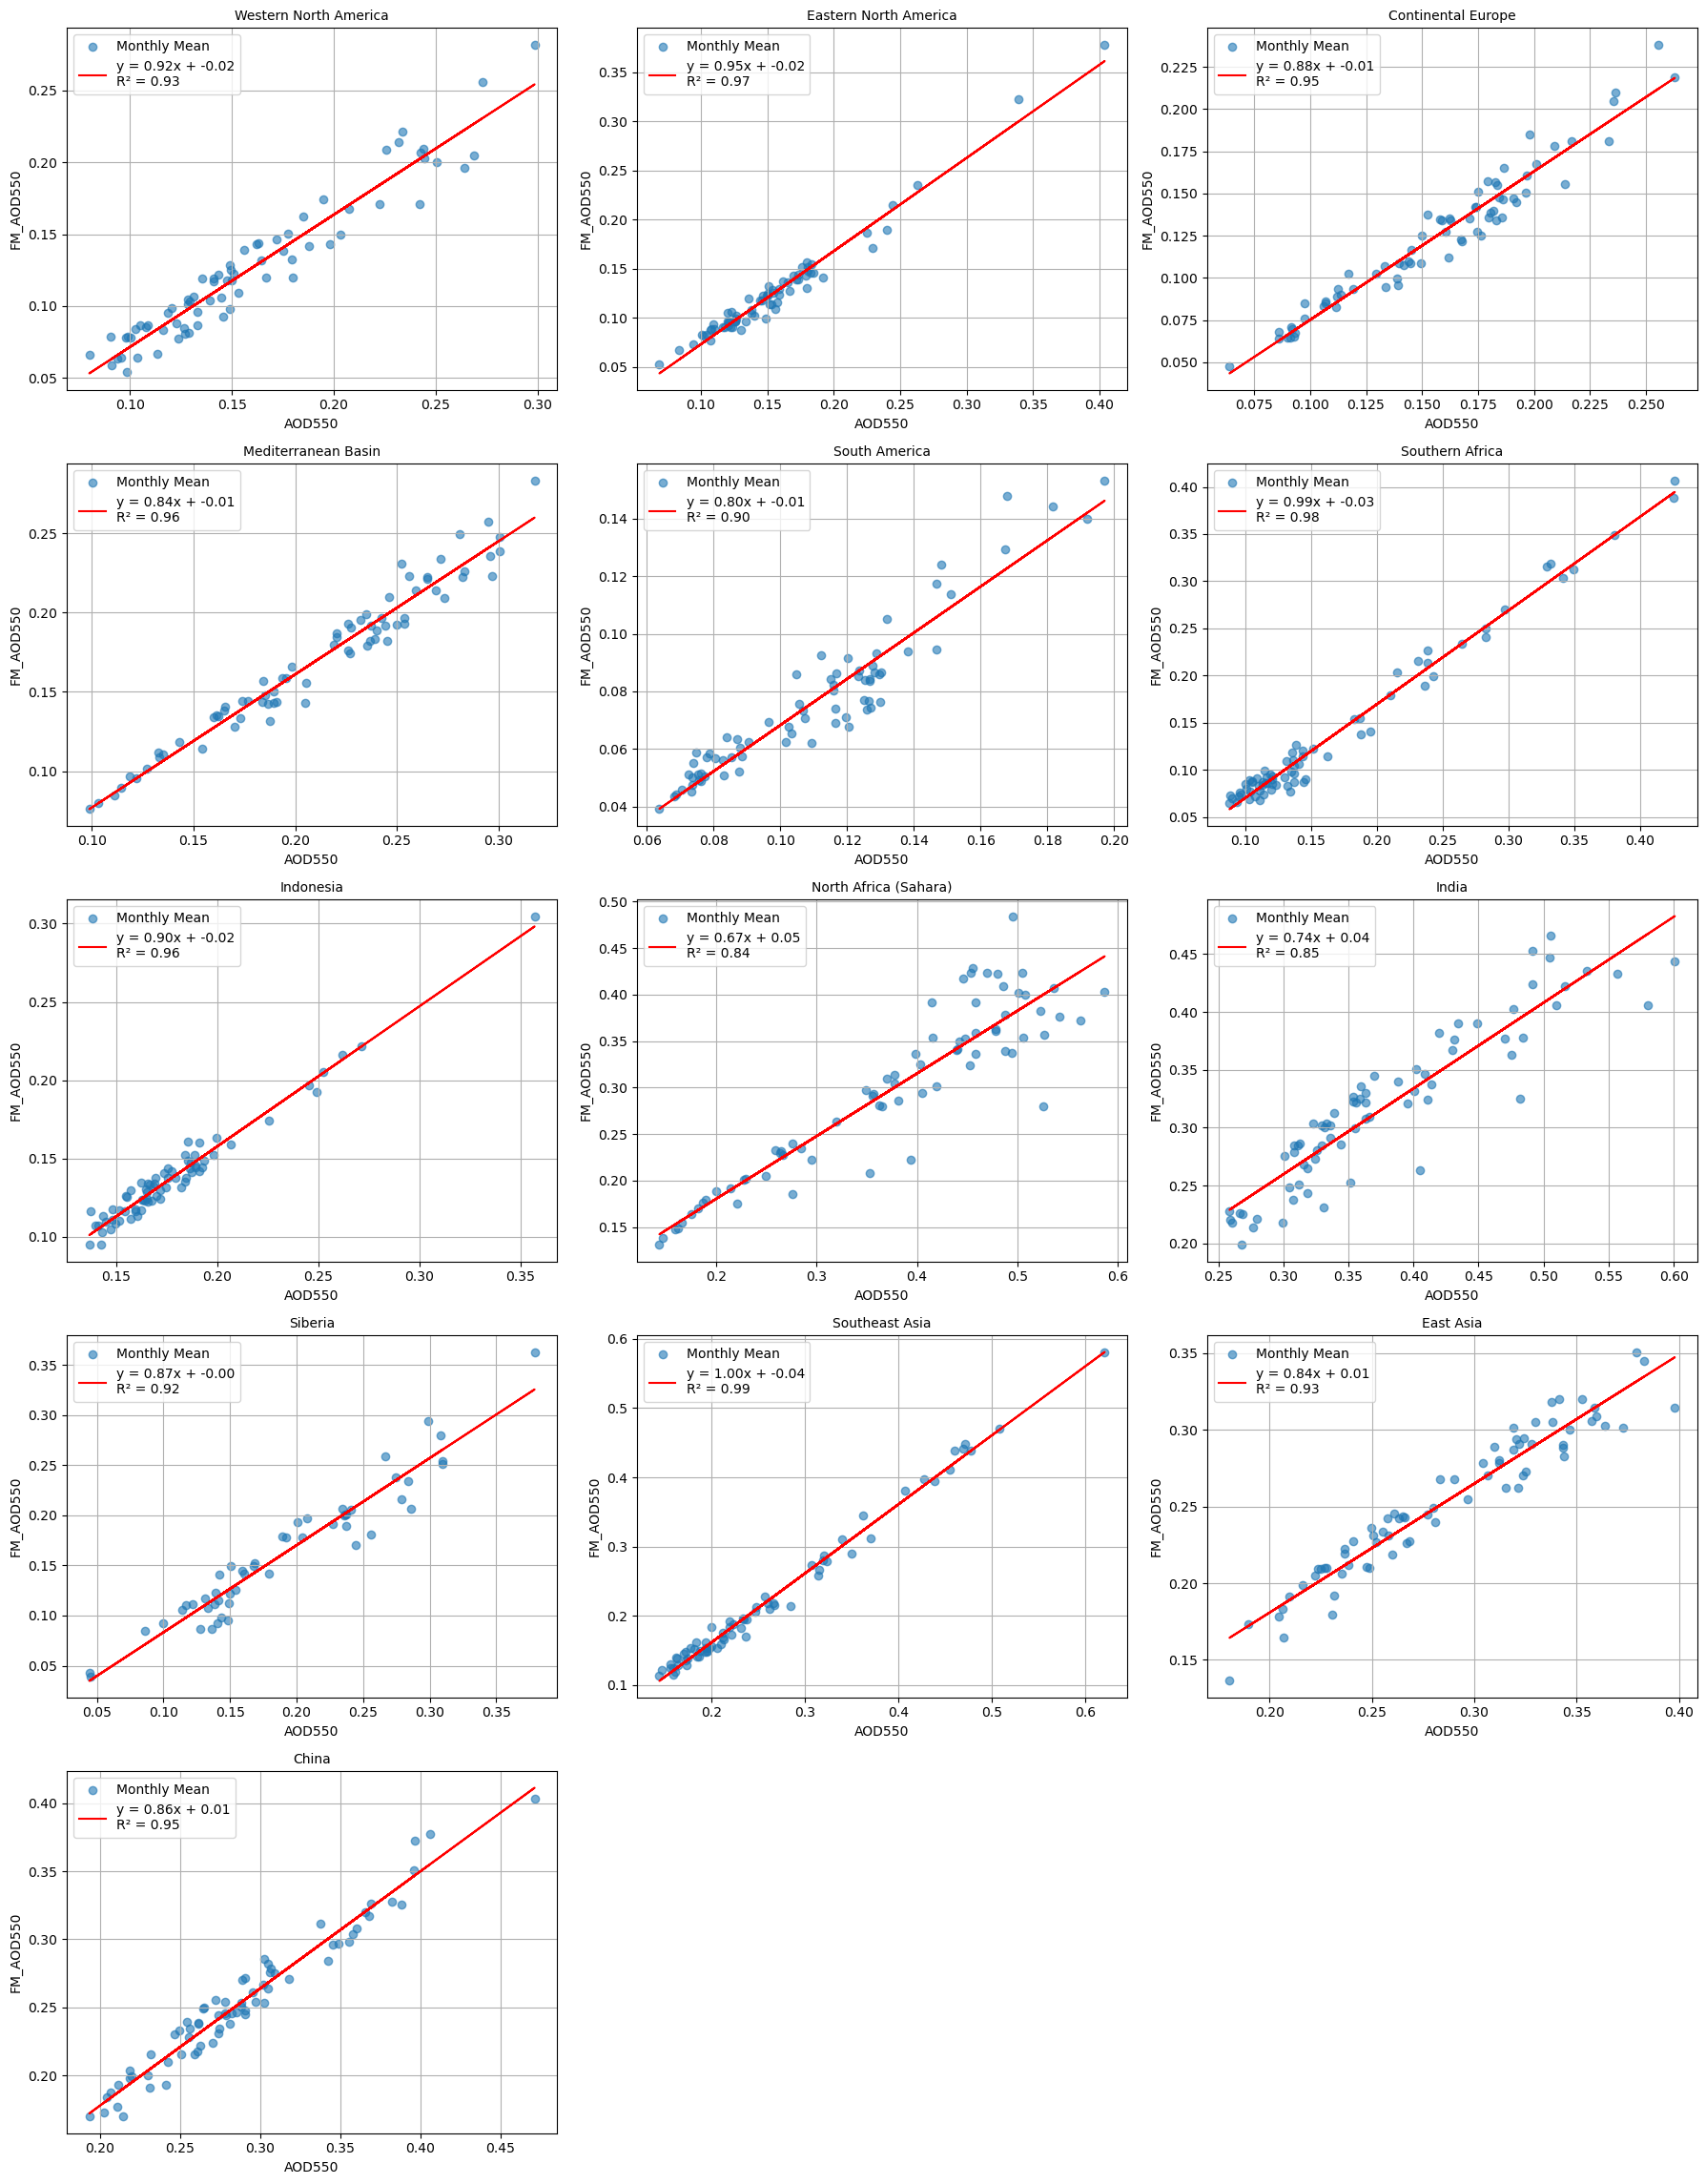

In [28]:
scatter_fine_vs_total(df, subregions)

*Figure 5.* Scatter plots of monthly mean Fine Mode AOD (FM_AOD550) vs. Total AOD (AOD550) for selected global subregions. Each panel includes a linear regression line (in red) with its corresponding equation and R² value.

(section-4)=
### 4. Take-Home Messages

The current aerosol climatology shows substantial deviations from earlier studies [1]. Over North Africa and the Mediterranean Basin, a significant increase in mineral dust intrusions was observed during 2020–2022, as reported by Cuevas-Agulló et al. (2024). This increase is associated with enhanced activity of high-pressure systems over the Euro-Atlantic sector, which favour the obstruction of the westerlies and the occurrence of cut-off lows at subtropical latitudes.
During the same period, the coarse-mode AOD fraction increased over the Mediterranean, further confirming the influence of mineral dust transport due to the atmospheric circulation in the Mediterranean Basin.
The weaker correlation between fine-mode and total AOD reflects the greater contribution of coarse-mode particles, particularly dust, rather than inconsistencies in retrieval.
In the Northern Hemisphere, seasonal variability remains generally consistent across the selected regions, dominated by continental aerosols and anthropogenic pollution.
Strong seasonal peaks are also observed in:
- Southern Africa, where higher AOD values in the Southern hemisphere are consistent with the occurrence of forest fires during the dry austral season (Aug-Sep-Oct) [2, 3].
- Southeast Asia, where AOD is influenced by local fires and aerosol transport from northern Australia [5].
In Siberia, several months of data are missing from the ensemble retrieval, making it difficult to assess seasonal variability.

## ℹ️ If you want to know more

### Key Resources

• Aerosol properties gridded data from 1995 to present derived from satellite observations:

https://cds.climate.copernicus.eu/datasets/satellite-aerosol-properties?tab=overview

Code libraries used:

• C3S EQC custom function, c3s_eqc_automatic_quality_control, prepared by B-Open

### References

[1] Remer, L. A., et al. (2008). Global aerosol climatology from the MODIS satellite sensors. Journal of Geophysical Research: Atmospheres, 113(D14S07). https://doi.org/10.1029/2007JD009661

[2] Nyasulu, M., Haque, M.M., Musonda, B. et al. The long-term spatial and temporal distribution of aerosol optical depth and its associated atmospheric circulation over Southeast Africa. Environ Sci Pollut Res 29, 30073–30089 (2022). https://doi.org/10.1007/s11356-021-18446-7

[3] Flamant, C., Chaboureau, J.-P., Gaetani, M., Schepanski, K., and Formenti, P.: The radiative impact of biomass burning aerosols on dust emissions over Namibia and the long-range transport of smoke observed during the Aerosols, Radiation and Clouds in southern Africa (AEROCLO-sA) campaign, Atmos. Chem. Phys., 24, 4265–4288, https://doi.org/10.5194/acp-24-4265-2024, 2024.

[4] Cuevas-Agulló, E. et al. (2024). Sharp increase in Saharan dust intrusions over the western Euro-Mediterranean... https://doi.org/10.5194/acp-24-4083-2024

[5] Jin, S. et al. (2023). A comprehensive reappraisal of long-term aerosol characteristics... https://doi.org/10.5194/acp-23-8187-2023

[6] Garrigues, S., Remy, S., Chimot, J., Ades, M., Inness, A., Flemming, J., Kipling, Z., Laszlo, I., Benedetti, A., Ribas, R. and Jafariserajehlou, S., 2022. Monitoring multiple satellite aerosol optical depth (AOD) products within the Copernicus Atmosphere Monitoring Service (CAMS) data assimilation system. Atmospheric Chemistry and Physics Discussions, 2022, pp.1-80.